# Digital Signal Processing for Speech, Language, & Hearing Scientists
# Chapter 5: Digital Filters

**Meg Cychosz**, *UCLA*

## Table of Contents
1. [Introduction](#introduction)
2. [Finite impulse response filters](#FIR)
    1. [Example #1: Moving average filters](#MAF)
        1. [A note about convolution](#convolution)
    2. [Example #2: Low-pass filters](#lowpass)
        1. [A note about filter order](#filterorder)
        2. [The effect of windowing](#windowing)
    3. [Example #3: Band-pass filters (Butterworth)](#bandpass)
    4. [Example #4: High-pass filters](#highpass)
    5. [Example #5: Pre-emphasis](#preemphasis)
    6. [Scaling the gain of FIR filters](#gain)
4. [Interpreting signal processing language](#language)
5. [Speech perception filters](#perception)
6. [Speech production filters](#production)
7. [Glossary](#glossary)

In [ ]:
import os, re
import parselmouth as pm
import librosa as lb
import numpy as np
import scipy as sc
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
path = os.getcwd()

## Introduction<a name="introduction"></a>  

In Chapter 2, we explored several ways of modulating a signal's amplitude. When we modulate the signal's amplitude at *specific* frequencies, we modify the sound's structure via **spectral shaping**. Filters are one example of spectral shaping that we use to 1) suppress parts of the signal that we don't want and/or 2) amplify parts of the signal that we do. Filters can take on different shapes depending upon the number and range of frequencies that we wish to keep.

Although this tutorial will focus on digital filters, there are all kinds of natural filters (digital and analog) around us every day. Speaking over a telephone is significantly more challenging than face-to-face communication, and this is in part due to the bandpass filter applied to telecommunication signals which only passes frequencies ranging from 400-4000Hz. Even something as simple as a wooden door in your house can act as a low-pass filter, passing through lower speech frequencies but attenuating higher ones.  

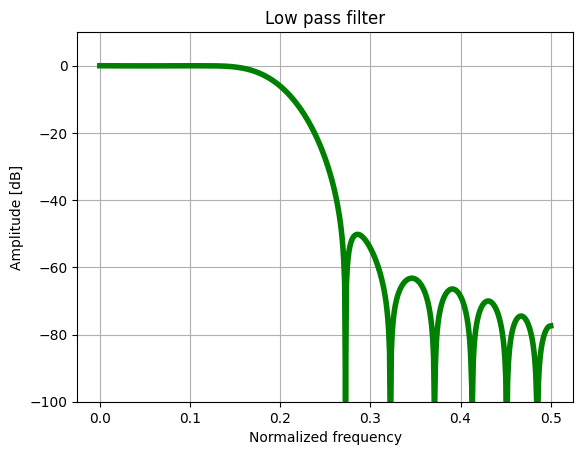

In [94]:
f = 0.2  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
N = 25    # Number of coefficients.
 

sr = 10000.0
chunk_size = 1024 # length of frequency response

t = np.arange(chunk_size) / sr
    
# Compute sinc filter and apply Hamming window.
n = np.arange(N)
h = np.sinc(2 * f * (n - (N - 1) / 2)) * np.hamming(N)
h /= np.sum(h)
 
# zero-pad to apply FFT
h_padded = np.zeros(chunk_size)
h_padded[0 : N] = h
 
# compute frequency magnitude responses from coefficients and keep first half
H = np.abs(fft(h_padded))[0 : chunk_size // 2 + 1]
 
plt.figure()
plt.plot(np.linspace(0, 0.5, len(H)), 20 * np.log10(H),lw=4,color='green')
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude [dB]')
plt.title('Low pass filter')
plt.ylim([-100, 10])
plt.grid()
plt.show()

To understand filters, it helps to first envision a complex sine-wave signal, such as one encompassing 2, 5, and 10Hz tones:

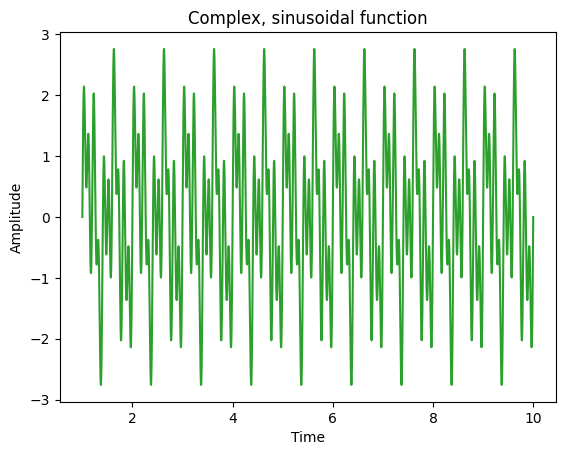

In [95]:
t = np.arange(1, 10, (1/44100))
comp = np.sin(t*(2*np.pi)*2)  + np.sin(t*(2*np.pi)*5)  + np.sin(t*(2*np.pi)*10) 

plt.figure()
plt.plot(t, comp, c='tab:green')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Complex, sinusoidal function")
plt.show()

If we want to filter out all frequencies of this signal > 2Hz, we have to separate the frequencies out. In signal processing, we accomplish this using **phase shifting** where we slightly move one signal in time, delaying its onset. For example, for a simple sine wave, we could shift the function one complete phase, creating two different functions. In the following plot, the orange function is delayed relative to the green. 

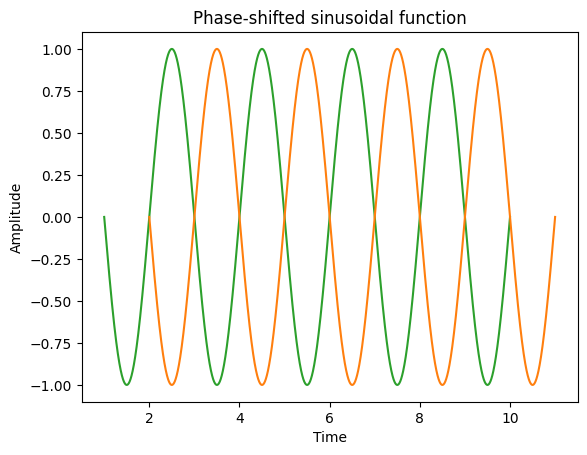

In [96]:
orig = np.sin(t*(2*np.pi)*.5) 
shift = np.sin(t*(2*np.pi)*.5)

plt.figure()
plt.plot(t, orig, c='tab:green')
plt.plot(t+1, shift, c='tab:orange')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Phase-shifted sinusoidal function")
plt.show()

When two sound waves meet, as they do in the above plot, they experience interference. 

Specifically, phase-shifting waveforms like this results in two phenomena that are relevant for filtering: **constructive interference**, when the combined sum of two waves magnifies the amplitude (the sum of both individual waves), and **destructive interference**, when the combined amplitudes cancel each other out. 

Constructive interference occurs when two waves meet. At that point in time, their amplitudes are added together and a new wave, taking into account the added amplitudes, is created. This new wave is reflected in the red function in plot 1 below. 

Destructive interference occurs when the waves are exactly 180 degrees (2π) out of sync. The amplitudes cancel out because the (positive) amplitude of the first wave is reflected in the (negative) amplitude of the second wave resulting in an amplitude of 0, as the red y-intercept in plot 2 shows below. 

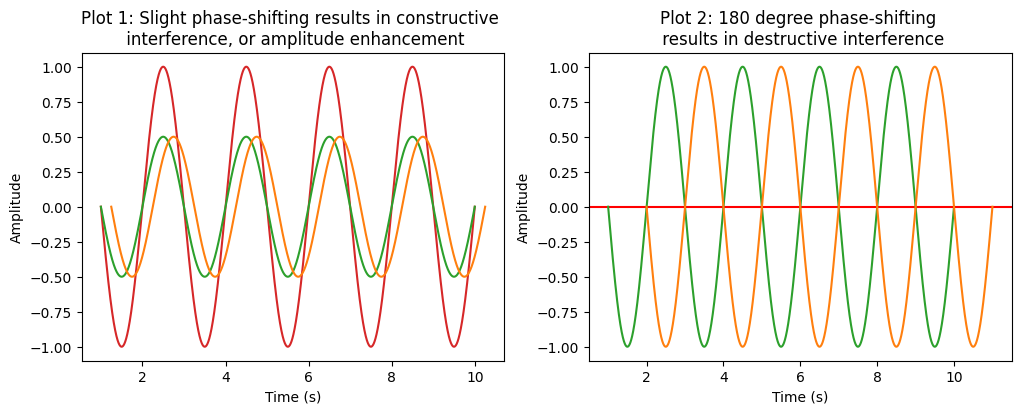

In [97]:
fig, axs = plt.subplots(1,2,figsize=(12, 4))
axs[0].set_title('Plot 1: Slight phase-shifting results in constructive \n interference, or amplitude enhancement')
axs[0].plot(t, (orig + shift)/2,'tab:red')
axs[0].plot(t, orig/2,'tab:green')
axs[0].plot(t+.25, shift/2,'tab:orange')
axs[1].set_title('Plot 2: 180 degree phase-shifting \n results in destructive interference')
axs[1].axhline(y=0, color='red')
axs[1].plot(t, orig,'tab:green')
axs[1].plot(t+1, shift,'tab:orange')

for ax in axs.flat:
    ax.set(ylabel='Amplitude', xlabel="Time (s)")

How do we phase shift a signal so that we can filter out certain frequencies and keep others? We accomplish this by taking advantage of constructive and destructive interference. When we shift a signal slightly, we increase its amplitude and when we shift a signal 180 degrees, we nullify the amplitude (reduce it to 0). So, it stands to reason, that if we want to *enhance* a certain frequency in a signal we should phase-shift it just slightly and if we want to *filter out* a certain frequency, we should phase shift it 180 degrees from the original function so that its amplitude is reduced to 0. 

There are, of course, handy functions that will automate any number of spectral filtering processes for you; these are included at the end of this notebook. However, to really understand filtering, it helps to know that when we phase shift a signal, we are replicating that signal but moving it slightly in time. Consequently, we can simply add the n-1 sample to the original signal to create a phase-shifted signal. 

## Finite impulse response filters<a name="FIR"></a> 

A digital filter is the process of manipulating a signal in the time domain to amplify or attenuate certain frequencies in the spectral domain. There are two broad types of linear digital filters: finite and infinite. In both cases, samples from an input sequence `x` in the time domain are combined (via addition, multiplication, etc.) to create an output sequence `y` for the spectral domain. Finite digital filters, or finite impulse response (FIR) filters, only act upon samples in the input sequence while infinite digital filters (infinite impulse response filters) act upon a combination of input samples and output samples that are computed during the course of filtering. As such, finite digital filters assume a finite number of samples in the output sequence while infinite digital filters assume an infinite number of samples. These differences will become clearer as we walk through examples of both types of filters, starting with FIR filters. 

### Example 1: Moving average filters<a name="MAF"></a> 

One of the simplest versions of an FIR filter is a moving average filter. Here you can think of the filter as a moving `window` that you progressively slide over the input samples. Input samples within the window, say N=5, are averaged (added together and divided by 5):

`y = (x[1] + x[2] + x[3] + x[4] + x[5])/5`

* where x is the input sequence and y the output sequence
* and `x[1]` refers to the first sample in the input sequence, `x[2]` the second sequence, etc. 

Then the window progresses one sample, discards the "oldest" sample, and N=5 more samples are averaged. 

In reality, for the types of signals that we work with (one-dimensional in the time domain), we multiply each input sample by another array of *coefficients* instead of dividing the N samples by N. But the result is the same.

`y = (.2*x[1] + .2*x[2] + .2*x[3] + .2*x[4] + .2*x[5])`

or really just:

`y = .2*(x[1] + x[2] + x[3] + x[4] + x[5])`

A term that often comes here is `taps`, referring to the number of samples used to compute the output sequence. Here we used 5 samples, so we constructed a 5-tap finite impulse response filter. In fact these two elements---the number of taps and the coefficient array---are the two most important elements of a filter. They help shape what the filter actually filters! 

We can program our own version of a simple moving average filter:

In [98]:
x = np.linspace(-10, 10, num=25) # the input sequence, in the time domain

y = np.convolve(x, 
                np.ones(5)/5, # another array, but of coefficients
                mode='valid') # ignore values that don't overlap between x and y

We can plot our input and output values in tables. It's pretty clear here that our moving average filter is filtering out the most extreme values: the original range was -10---10 but the range of output values only spans ~-8.3---8.3. As such this filter is acting as a basic **low-pass filter**, where the lower frequencies in the signal are passed through and the highest frequencies in the signal are attenuated. 

In [ ]:
pd.DataFrame(x,columns=['input'])

In [ ]:
pd.DataFrame(y,columns=['output'])

Another thing to notice is that our input sequence is longer than our output sequence. This is because we specified `valid` mode within `np.convolve`, which meant that we wanted to ignore any indexes that did *not* overlap between our input and output sequences. In other words, for a moving average filter working over N=5 samples, the filter only started operating at `x[5]` because there weren't 5 samples to average over at `x[1]`, `x[2]`, etc. We could specify different numbers for this **filter unit-delay** element `D`. We could also choose to apply the N-tap FIR filter before we have all N taps in the input sequence to compute the output. In that case, the first N-1 output samples (the filter's **transient response**) might not "count" or be of interest to us.

In the `np.convolve` example above we multiplied the input sequence by an array of coefficients *with the same value*. But in reality, we often perform these calculations over a coefficient array with *different* values which you'll see represented with `h` in the literature. At this point, we can start referencing the number of taps with `n` as well:

`y = (h(4)*x[n-4] + h(3)*x[n-3] + h(2)*x[n-2] + h(1)*x[n-1] + h(0)*x[n])`

* where `h(x)` refers to the array of filter coefficients 

The terms *FIR filter coefficients* and *impulse response* are used interchangeably; we will use filter coefficients for consistency in this tutorial. 

At this point it's worth returning to our earlier discussion about phase shifting as a form of filtering. First we'll generate a new input sequence, in the form of a sinewave:

In [101]:
t = np.arange(0,5,1/10)
x = np.sin(t*(2*np.pi)*.5) 

Then we'll convolve the input sequence to generate our output. Here I simply padded the output sequence with zeros to account for the filter unit delay, but you could have calculated and plotted an actual transient response instead. 

In [102]:
N = 5 # number of taps
y = np.convolve(x,np.ones(N)/N,"valid")
full_y = np.concatenate([np.zeros(N-1), y])

Now if we plot our input and output sequences, we should see a pattern emerge, namely, the output sequence is just a phase-shifted version of the input sequence. 

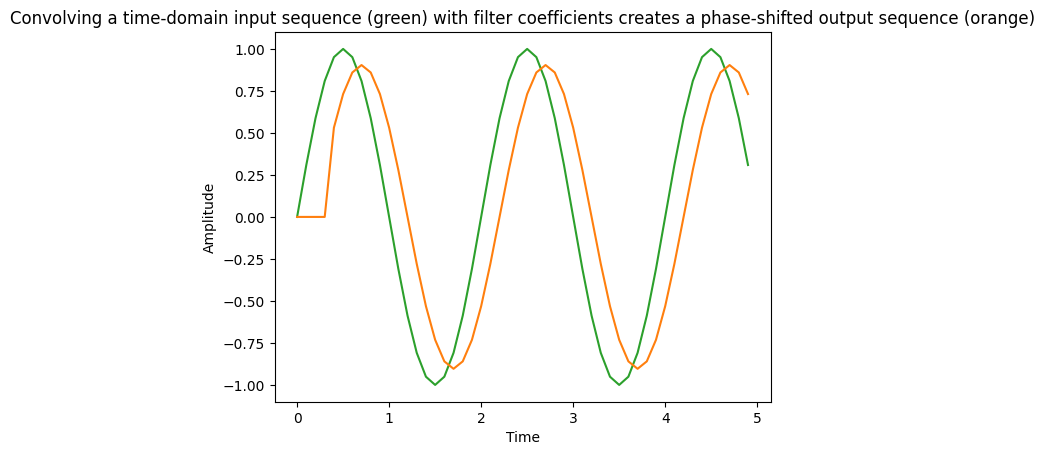

In [103]:
plt.figure()
plt.plot(t, x, c='tab:green')
plt.plot(t, full_y, c='tab:orange')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Convolving a time-domain input sequence (green) with filter coefficients creates a phase-shifted output sequence (orange)")
plt.show()

### A note about convolution<a name="convolution"></a> 

Another term that frequently arises here, and indeed was already introduced in the moving average filter code, is **convolution**. It's not necessary to understand all of the mathematical details behind convolution to understand digital filters, although it's worth appreciating what convolution does for us in signal processing. 

Convolution is the process of combining two signals together. In FIR filters, convolution refers to summing together a series of products. Here, as we have seen, each product is the result of multiplying a sample in our input sequence by a filter coefficient `h(k)*x(n)` and the sum of these products is a sample in our output sequence. So, output sequences are the result of convolving input sequences with filter coefficients. 

Things get a bit more complicated from here. There are special relationships between input sequences, output sequences, and filter coefficients. The important thing to remember is that convolution in the time domain equals multiplication in the frequency domain. So when we convolve an input sequence with filter coefficients (`h(k)~x(n)` where ~ represents convolution), this is the same as multiplying the DFT of the input sequence by the DFT of the filter coefficients (`H(k)*X(n)`). So we say that convolution (remember, that's just the process of combining the input sequence with the filter coefficients) in the time domain is the same as multiplication in the frequency domain for any two given signals. 

### Example 2: Low-pass filters<a name="lowpass"></a> 

Again, the two most important parameters in filter design are the *number* of taps and the *value* of the coefficients. So at this point, it might, reasonably, be more interesting to experiment with different filter coefficients.  

We've been assuming uniform coefficient values, but if we alter those values slightly we can plot new frequency responses. Let's simulate a few different coefficient value arrays to see how they impact our output. 

First we create some arrays of coefficients. We could do this by hand:

In [104]:
uniform =[0.2,0.2,0.2,0.2,0.2]
small = [0.04,0.12,0.2,0.12,0.04]
large = [0.0,0.2,0.4,0.2,0.4]

Or we could use the `firwin` function from scipy's signal processing (`signal`) library which allows us to specify some more detailed parameters such as how many taps we would like to take, what type of window we would like to apply to the filter coefficients (more on this in a bit), and pre-determining the cut-off in the frequency response (the maximum frequency value):

In [105]:
# create several different low-pass FIR filters from 0 to f 
f=0.1
numtaps = 100

# switch up the number of taps/coefficients 
ntaps=[5,20,50,100]
ntap_filters = []
for n in ntaps:
    h = sc.signal.firwin(numtaps=n, 
                 cutoff=f, # generally fs/2
                 window='hamming',  
                 fs=22000)
    ntap_filters.append(h)
    
# switch up the windowing function
windows = ['hamming','blackman','rectangular','tukey']
win_filters = []
for w in windows:
    h = sc.signal.firwin(numtaps=numtaps, 
                 cutoff=f, 
                 window=w,  
                 fs=22000)
    win_filters.append(h)

Regardless of which method we used above, the coefficient arrays were all examples of *constant coefficients* meaning that the coefficient values do not change as the window slides across the input `x` sequence. There are other digital FIR filters that are time-invariant, meaning that these values would change, but we won't be working with those now. 

Next we have to compute the DFT of the coefficient arrays and plot the frequency magnitude response. This is a key point to understand: to compute the frequency response of a filter---the filter's shape or which frequencies it attenuates and how quickly it does so---we take the DFT of the *coefficient array*:

Text(0.2, 1.1, 'large coefficient range')

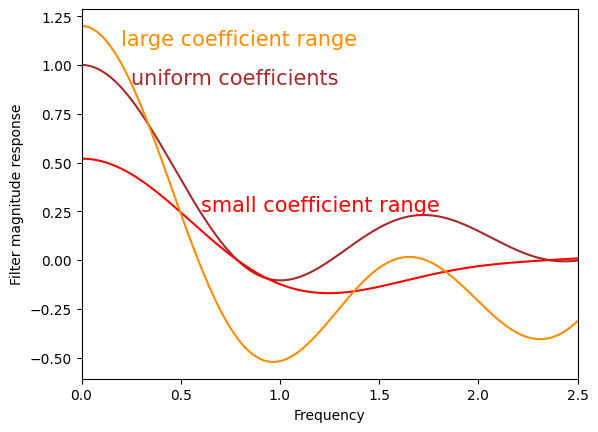

In [106]:
# compute frequency response of digital filter for the arrays we created by hand
freq, amp = sc.signal.freqz(uniform) 
s_w, s_h = sc.signal.freqz(small)
l_w, l_h = sc.signal.freqz(large) 

plt.figure()
plt.plot(freq,amp,'brown')
plt.plot(s_w,s_h,'red')
plt.plot(l_w,l_h,'darkorange')
plt.xlim(0,5/2)
plt.ylabel("Filter magnitude response")
plt.xlabel("Frequency")
plt.annotate('uniform coefficients',(0.25,.9),size=15,color = 'brown')
plt.annotate('small coefficient range',(0.6,.25),size=15,color = 'red')
plt.annotate('large coefficient range',(0.2,1.1),size=15,color = 'darkorange')

In the plot above, the largest "bumps" in the frequency response (known as **sidelobes**) appear in the orange function, representing the filter magnitude response for the large coefficient range. The smallest sidelobes occur for the function representing the frequency response for the small coefficient range. Large "jumps" between filter coefficients in the array also lead to a steeper roll-off in the **transition band**, or the range of frequencies between the frequencies that are passed through the filter and those that are attenuated (see plot below for illustration). And finally, you can note the well-known inverse relationship between roll-off rate and sidelobe magnitude: a faster roll-off rate results in larger sidelobes in the frequency response function of digital filters. 

Text(0.35, -57, 'stop band')

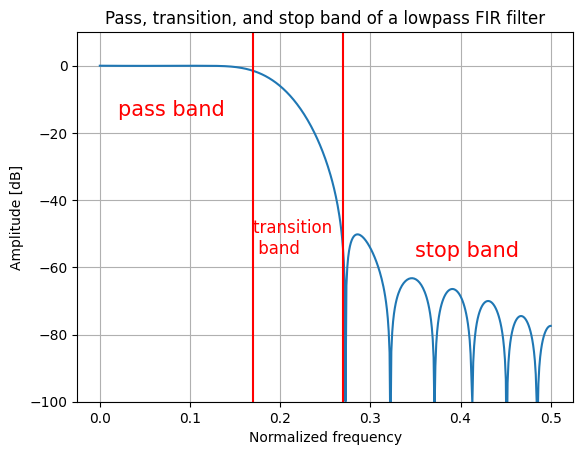

In [107]:
plt.figure()
plt.plot(np.linspace(0, 0.5, len(H)), 20 * np.log10(H))
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude [dB]')
plt.title('Pass, transition, and stop band of a lowpass FIR filter')
plt.ylim([-100, 10])
plt.grid()
plt.axvline(x = .17, color = 'red', label = 'XX')
plt.axvline(x = .27, color = 'red', label = 'XX')
plt.annotate('pass band',(0.02,-15),size=15,color='red')
plt.annotate('transition \n band',(0.17,-56),size=12,color='red')
plt.annotate('stop band',(0.35,-57),size=15,color='red')

There is also a relationship between sidelobe size and bumps in the **passband** or the range of frequencies that are allowed through the filter. The bumps in the passband are known as **passband ripple**, or spectral ripple, and they are ubiquitous in digital filters. We won't get into the mathematics behind *why* these two components of the filter are related; it's sufficient to know that they have an inverse relationship: larger sidelobes are correlated with smaller passband ripples. 

So, thus far, we have:
1. hand-picked our coefficients
2. applied a DFT to the coefficients
3. viewed our low-pass filter

We could sit here forever and manipulate the values of our coefficients, hoping to eventually stumble upon the frequency response that we desire. Or, we could:

1. choose our filter design in the frequency domain
2. apply an *inverse* DFT
3. derive the filter coefficients

So let's do that!

In the for loops above, we manipulated the number of taps taken in the filter and the windowing function that we applied to the filter coefficients. The plots below illustate how these parameters affect the frequency magnitude response.

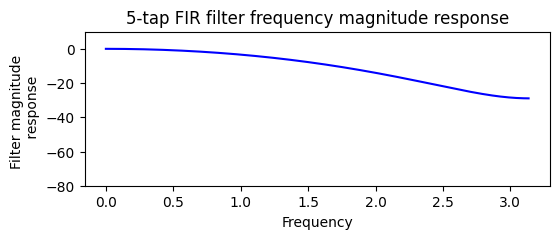

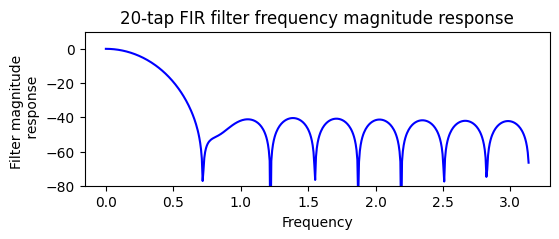

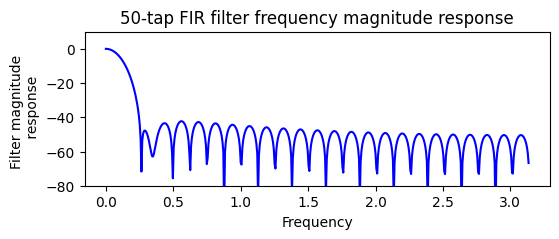

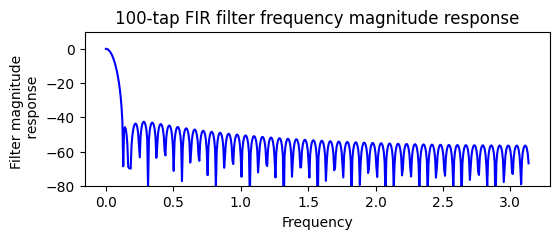

In [108]:
for f in ntap_filters:
    ntaps = len(f)
    freq, amp = sc.signal.freqz(f) 
    plt.figure(figsize=(6,2))
    plt.plot(freq,20*np.log10(np.abs(amp)/np.abs(amp).max()),color='blue')
    plt.ylabel("Filter magnitude \n response")
    plt.xlabel("Frequency")
    plt.title('{}-tap FIR filter frequency magnitude response'.format(ntaps))
    plt.ylim(-80,10)

More taps in the filter permits a steeper roll-off in the transition band. The more taps we use, the closer we approximate our idealized low-pass filter. However, more taps also result in large sidelobes (and larger ripples in the passband, although this is less apparent here). 

### A note about filter order<a name="filterorder"></a>

This is a good point to clarify some terminology that is floating around. The plots above illustrate the relationship between number of filter taps and filter steepness, or the transition band roll-off. Filter roll-off is also known as the **attenutation rate**. Steepness is clearly an important characteristic of a filter's frequency response, so we classify filters along this dimension according to their **filter order**, or the number of taps taken in a FIR filter. 

So if we have input sequence `x`:

        x = np.array(0,10)
        
a 1st order filter order would use `x[n-4]` to calculate output sequence `y`, 2nd order would use `x[n-4]` and `x[n-3]`, etc.  

For an input sequence `x`, can you guess what a 0-order filter response would be? That would mean that our input sequence = the output sequence (`x`=`y`). 

A higher filter order indicates a faster roll-off or attenuation rate in the transition band (a steeper slope), getting us closer to our idealized filter frequency response. But larger filter orders are also more computationally taxing because more samples are multiplied/added as the window slides along the input sequence. 

But filter orders are actually more interesting than simply higher versus lower. Not only does a higher filter order indicate a faster roll-off, the *particular* filter order number indicates something as well. For example you might see the following written:

"*a 4th order Butterworth low-pass filter"*

We'll cover Butterworth filters in a bit, but we can use this "4th order" information to compute the dB/octave roll-off rate within the transition band.

Here's how to figure out the dB/octave roll-off rate:

    6dB/octave = 1st order
    12dB/octave = 2nd order
    18dB/octave = 3rd order

So third order has a steeper roll-off rate than 2nd, 4th order filter has a roll-off rate 2x that of a 2nd order filter, etc.

Filter orders of 2-6 are quite common. We use higher filter orders (like 12th order filters) when we want really fast roll-offs in the transition band (steep slope). 

### A note about the Nyquist frequency<a name="nyquist"></a> 

In our earlier discussion about aliasing, we mentioned that frequencies above Nyquist are attenuated. This is done by applying a low-pass filter during ADC (which you now understand). However, now that you know that filters are not infinitely steep, and have a non-0 slope, we should actually amend our understanding of the Nyquist frequency. The reason for this is that if we try to represent frequencies that are just *close* to Nyquist (e.g. 7998Hz sampled at 16kHz), aliasing will still occur. The low-pass filter does a non-perfect job attenuating frequencies above Nyquist, allowing some through to the signal. In practice, we should apply the *Engineer's Nyquist frequency*, or 2.5 times the sample rate, to avoid any potential aliasing effects stemming from non-perfect low-pass filters. 

### Telephone bandwidths

The telephone bandwidth is an example of a bandpass filter. This filter attenuates frequencies below approximately 300Hz and above 3400kHz. Telecommunication systems were initially designed this way to aid in the demands that higher sampling rates would have placed upon them. 

The telephone bandwidth/bandpass filter explains why certain sounds are particularly difficult to perceive over phones. For example, the bulk of the energy concentration in fricatives such as [s] (anywhere from 6-9kHz depending upon the size of the speaker's anterior cavity during [s] production) is well above the telephone bandpass cutoff. So most of this fricative spectral energy will be conveyed through a phone. This isn't a significant problem for communication, because our speech perception and language processing systems are so well-equipped at "filling in the blanks" via top-down cues. For example, even if the acoustic cues to [s] during the sentence "The cats played with one another" are not conveyed over a phone, an adult speaker would have little trouble inferring that "cats" was plural from the surrounding lexical context. 

There are efforts in place to widen the telephone bandwidth for cell phones, in particular to include higher-frequency sounds. Children may stand to benefit the most from these improved signal bandwidths. For one thing, children are much less equipped than adults at top-down processing like in the "cats" example above, so they may require more high-frequency acoustic cues to understand speech. Also, adults' hearing, especially high-frequency hearing, steadily worsens with age so even if those higher frequencies were conveyed, some adults would be less apt at taking advantage of them. And finally, children speak in higher frequency ranges than adults. Fricative spectral peaks are well above 3.4kHz for all speakers, from a little preschooler to Arnold Schwarzenegger. But 3.4kHz is *right* around the range of a typical third formant frequency in a 5- to 6-year-old (Lee et al., 1999), meaning that important cues to rhotics and vowels are absent in child speech conveyed through a telephone. So telephone signal bandwidths affect both children's perception *and* production of speech! 

### The effect of windowing<a name="windowing"></a> 

Although sidelobes and the passband ripple are mathmatically inherent to our filter design (finite number of filter taps), there are ways to manipulate their size. Windowing the FIR filter is one such approach. The plots below illustrate the effect of various filters upon the filter's frequency response.  

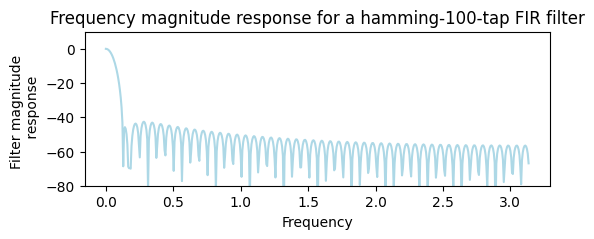

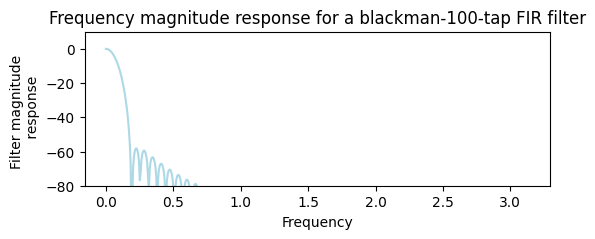

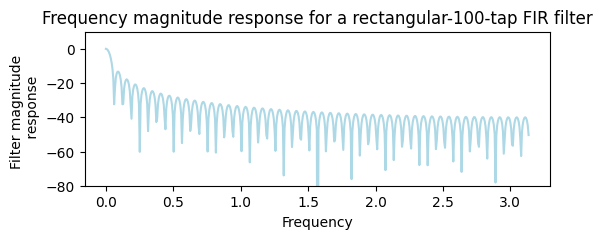

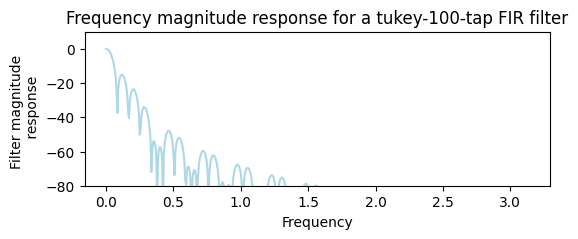

In [109]:
pltv = 0
for w in win_filters:
    freq, amp = sc.signal.freqz(w) 
    plt.figure(figsize=(6,2))
    plt.plot(freq,20*np.log10(np.abs(amp/np.abs(amp).max())),color='lightblue') # sidelobe details are too small to see on linear scale, so convert to logarithmic 
    plt.ylabel("Filter magnitude \n response")
    plt.xlabel("Frequency")
    plt.title('Frequency magnitude response for a {}-100-tap FIR filter'.format(windows[pltv]))
    plt.ylim(-80,10)
    pltv += 1

As you can see, the steepest roll-off, but the largest sidelobes (and thus greatest passband ripple) are caused by the *rectangular* window function. Why does this occur?

One way of understanding why rectangular window functions cause the largest sidelobes is to simply apply a rectangular window function to 5 coefficients. Really all this means is that we have an array of uniform coefficients, but it helps to visualize it:

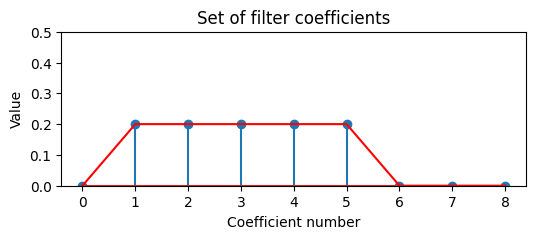

In [110]:
uniform2 = np.pad(uniform, (1, 3), mode='constant')

plt.figure(figsize=(6,2))
plt.stem(np.arange(0,9),uniform2)
plt.ylabel("Value")
plt.xlabel("Coefficient number")
plt.ylim(0,0.5)
plt.title('Set of filter coefficients')
plt.plot(np.arange(0.001,9.001),uniform2,color='red')

When we multiply an array of filter coefficients by a rectangular window function, the result is steep amplitude discontinuities between 0 and each coefficient value. Just like we reduced leakage by using different windowing functions during the Fourier transform tutorial, we can also reduce the size of the sidelobes (and thus ripples in the passband) in our frequency magnitude response by using different windowing functions. 

Take another look at the frequency magnitude responses for the different windows. The effect of Hamming (and Hanning) windows, which create smoother discontinuities between coefficient values, is smaller sidelobes, albeit with a shallower passband. 

Other windowing functions, such as Chebyshev and Kaiser, give us even *more* flexibility in the frequency magnitude response. In the Chebyshev window function, for example, we can directly manipulate the **attentuation rate** (in dB) of the window. We do not have this option with many other windows (rectangular, Blackman, etc.). Consider the following code:

Text(80, 0.7, '80')

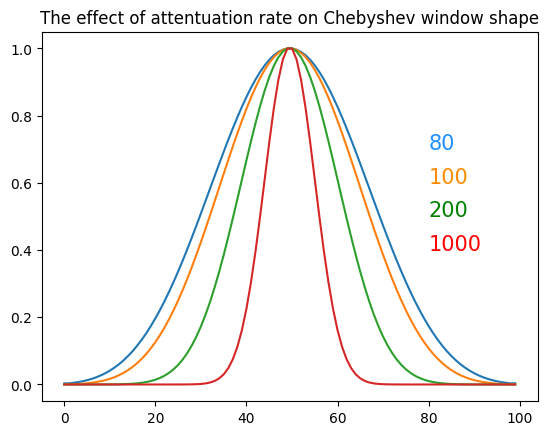

In [111]:
att_rate = [80,100,200,1000] # different attenuation rates

cheb_win = []
for r in att_rate:
    window = sc.signal.chebwin(100, at=r)
    plt.plot(window)
    plt.title('The effect of attentuation rate on Chebyshev window shape')
    cheb_win.append(window)
plt.annotate('1000',(80,0.4),size=15,color = 'red')
plt.annotate('200',(80,0.5),size=15,color = 'green')
plt.annotate('100',(80,0.6),size=15,color = 'darkorange')
plt.annotate('80',(80,0.7),size=15,color = 'dodgerblue')

Visualize the effect of Chebyshev window attenuation rate on frequency magnitude response:

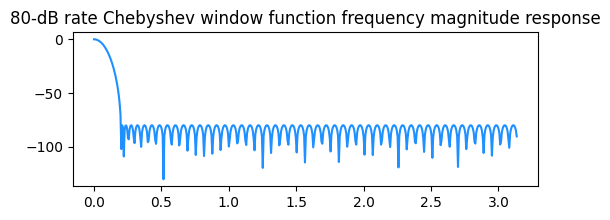

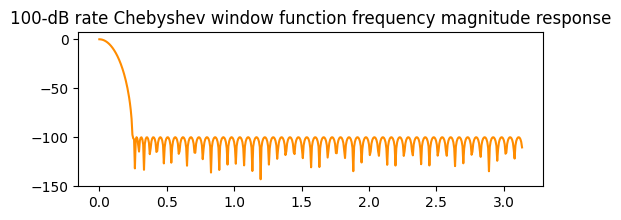

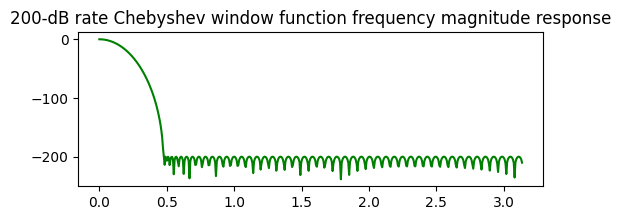

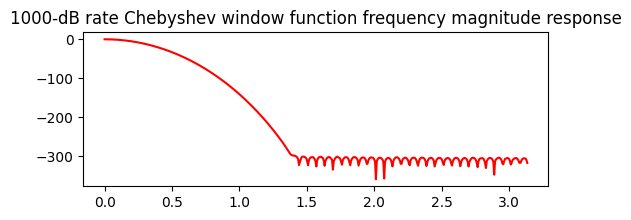

In [112]:
colors = ['dodgerblue','darkorange','green','red']
for win, att, c, in zip(cheb_win, att_rate, colors):
    freq, amp = sc.signal.freqz(win) 
    plt.figure(figsize=(6,2))
    plt.plot(freq,20*np.log10(np.abs(amp/np.abs(amp).max())),color=c) # sidelobe details are too small to see on linear scale, so convert to logarithmic 
    plt.title('{}-dB rate Chebyshev window function frequency magnitude response'.format(att))

The Kaiser window function also allows the user to manipulate the passband attenuation rate. The plots below illustrate the relationship between the parameter beta in the Kaiser window function and the size of the window. A larger beta results in a narrower window and shallower passband attenuation rate. 

Text(80, 0.7, '6')

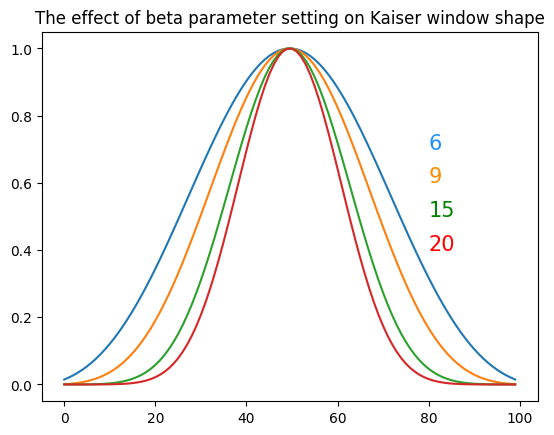

In [113]:
betas = [6,9,15,20] # different beta parameter settings

kais_win = []
for b in betas:
    window = sc.signal.kaiser(100, beta=b) 
    plt.plot(window)
    plt.title('The effect of beta parameter setting on Kaiser window shape')
    kais_win.append(window)
plt.annotate('20',(80,0.4),size=15,color = 'red')
plt.annotate('15',(80,0.5),size=15,color = 'green')
plt.annotate('9',(80,0.6),size=15,color = 'darkorange')
plt.annotate('6',(80,0.7),size=15,color = 'dodgerblue')

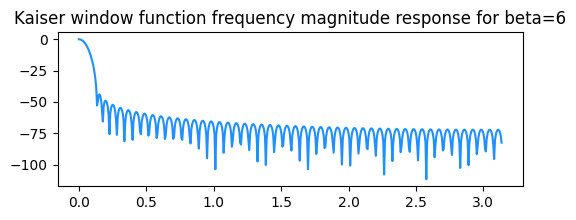

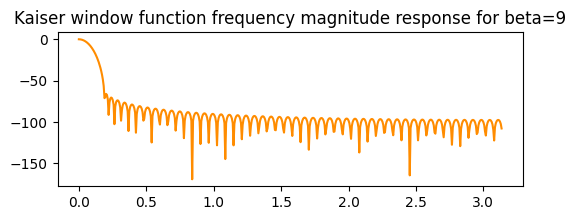

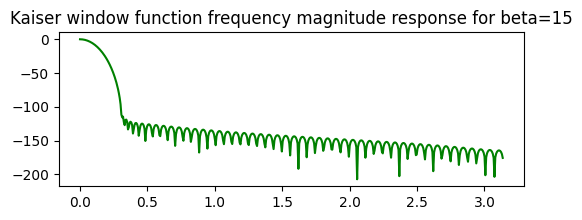

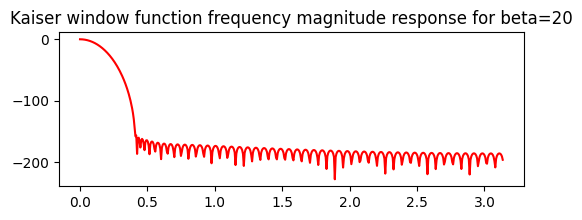

In [114]:
for win, b, c, in zip(kais_win, betas, colors):
    freq, amp = sc.signal.freqz(win) 
    plt.figure(figsize=(6,2))
    plt.plot(freq,20*np.log10(np.abs(amp/np.abs(amp).max())),color=c) # convert to dB
    plt.title('Kaiser window function frequency magnitude response for beta={}'.format(b))

### Example 3: Bandpass filters (Butterworth)<a name="bandpass"></a>

The examples above all concerned low-pass filters, where we tried to attenuate higher frequencies. Other common types of filters include bandpass filters, where we attenuate frequencies below and above a certain range, and high-pass filters, where we attenuate frequencies below a certain level. With a strong understanding of low-pass filters, it's relatively straightforward to understand and create bandpass and high-pass filters. 

Our low-pass filters' frequency magnitude responses above were always centered on 0 Hz. Even though in the plots above, we tended to only portray the positive frequencies in the frequency magnitude response, in reality our window functions are centered around 0, however. If we want to attenuate frequencies below and above a certain range, we have to re-center our filter coefficients. So in reality, a bandpass filter is just a low-pass filter shifted along the frequency dimension! 

This is a good time to mention one of the most common types of filters, the Butterworth filter, which is widely used in signal processing applications because it has very low passband ripple, or a very flat frequency response in the passband. A Butterworth filter can be a low-pass filter, a high-pass filter, or a passband filter. Butterworth filters are not immune from the well-established relationship between passband ripple and transition band width. What we gain in reduced passband ripple in the Butterworth filter, we lose in the transition band width which is wider relative to other window functions. 

### Example 5: Pre-emphasis<a name="preemphasis"></a>

In signal processing, windows aren't just for the time domain---they can be applied in the frequency domain as well. One example of windowing in the frequency domain is **pre-emphasis**, or increasing the amplitude of higher frequencies in the spectrum. 

In our signals, we traditionally expect that amplitude should decrease in the higher frequencies. Sometimes we refer to this as the spectrum "decaying." And indeed you can see this for yourself in the spectral depiction of the vowel from the baby vocalization:   

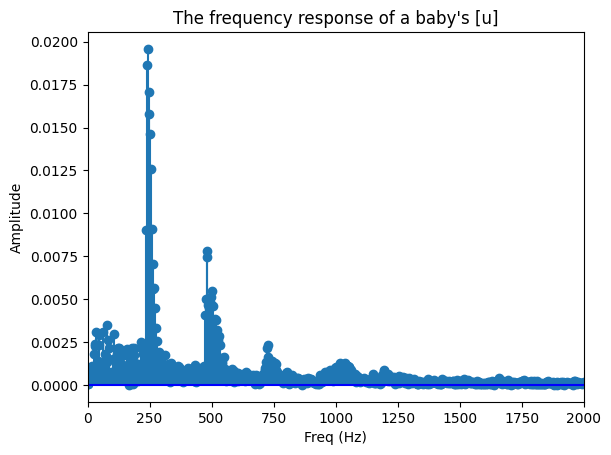

In [116]:
# read in the baby vocalization 
path = os.getcwd()
sound_file, baby_sr = lb.load(path+'/files/Cychosz_105_740_1138.76_1139.83.wav',sr=16000)

# apply Fourier transform to the first vowel 
v = fft(sound_file[:5000])

# get frequency response
N = len(v)
nyq = N//2
freq_comp = ((np.arange(N)*baby_sr)/N)[:nyq]
amp_comp = v[:nyq]/nyq

plt.figure()
plt.stem(freq_comp, abs(amp_comp), basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0,2000)
plt.title('The frequency response of a baby\'s [u]')
plt.show()

We can see that the energy is concentrated on the left side of the plot (lower frequencies) and that higher frequencies in the signal have a smaller amplitude. Let's explore the underlying process of pre-emphasis, and then apply it to our signal. 

We pre-emphasize a signal in the time domain by applying a first order differencing filter. That sounds fancy, but it just means that we compute the difference between adjacent samples in our input signal. We can also scale one of those samples to control the amount of pre-emphasis.

    y(n) = x(n) − α * x(n−1)

* where `x` is the input signal so `x(n)` is a sample in the input signal and `x(n-1)` is the previous sample
* `α` is the scalar (typically 0-1) to control the amount of pre-emphasis
* and `y` is the output signal

Pretty straightforward!

When we translate that into language that the computer can read it looks like this:

In [ ]:
v = sound_file[:5000]
emph_sound = np.append(v[0], v[1:] - 0.97 * v[:-1])

The above code is scaling the `x(n-1)` sample, taking the difference between `x(n)` and `x(n-1)`, and appending the result to a new array. We can then apply the FFT as before and plot the result:

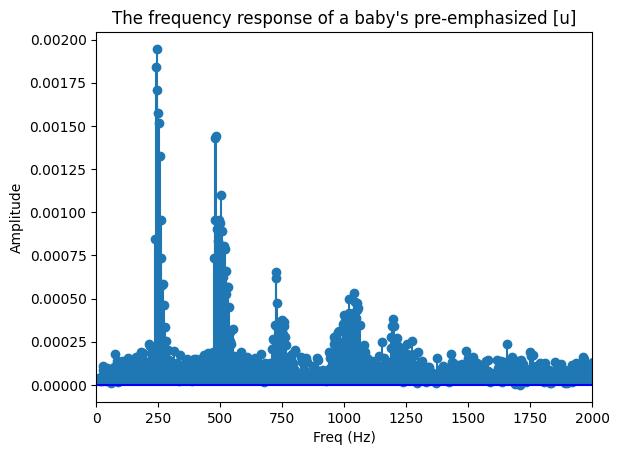

In [118]:
v = fft(emph_sound)

# get frequency response
N = len(v)
nyq = N//2
freq_v = ((np.arange(N)*baby_sr)/N)[:nyq]
amp_v = v[:nyq]/nyq

plt.figure()
plt.stem(freq_v, abs(amp_v), basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0,2000)
plt.title('The frequency response of a baby\'s pre-emphasized [u]')
plt.show()

Fortunately, we don't *need* to write out a first-order differencing filter every time we want to pre-emphasize a signal. There are built-in functions, like Librosa's `lb.preemphasis`, that work just as well. Many audio signal processing functions like this additionally allow you to specify the *amount* of pre-emphasis. In `lb.preemphasis` this is controlled in the `coef` argument which takes a number between 0 and 1 where 0 applies no pre-emphasis to the signal and 1 applies a first-order differencing filter. You can read more about that [here](https://librosa.org/doc/main/generated/librosa.effects.preemphasis.html). 0.95 and 0.97 are pretty typical amounts of pre-emphasis in the DSP literature. 

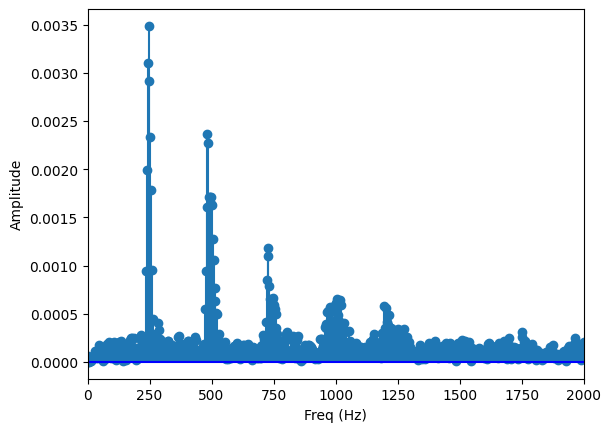

In [119]:
sound_up = lb.effects.preemphasis(v[:5000],coef=0.97) # play around with the coef argument to see how it affects the 
                                                     # the spectral tilt
                                                     

# visualize the pre-emphasized sound
# note the different y-axis scale
plt.figure()
plt.stem(freq_comp, abs(sound_up[:nyq]/nyq), basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0,2000)
plt.show()

# and listen to it
ipd.Audio(data=sound_up,rate=baby_sr)

Now, there are, obviously, exceptions to this relationship between frequency and amplitude. Certain sounds, like fricatives, actually have *higher* concentrations of energy at the highest frequencies. So we don't want to apply pre-emphasis across-the-board to a signal without reflecting on the acoustic properties of individual speech sounds. 

We can similarly apply **de-emphasis**, which is, as you might have guessed, when we *reduce* the amplitude of a certain frequency range in the spectrum. But I'll leave it to you to figure out how to compute that!

### Scaling the gain of FIR filters<a name="gain"></a> 

A filter's pass band gain refers to the frequency magnitude response in the passband, or the y-intercept around which the spectral ripple oscillates:

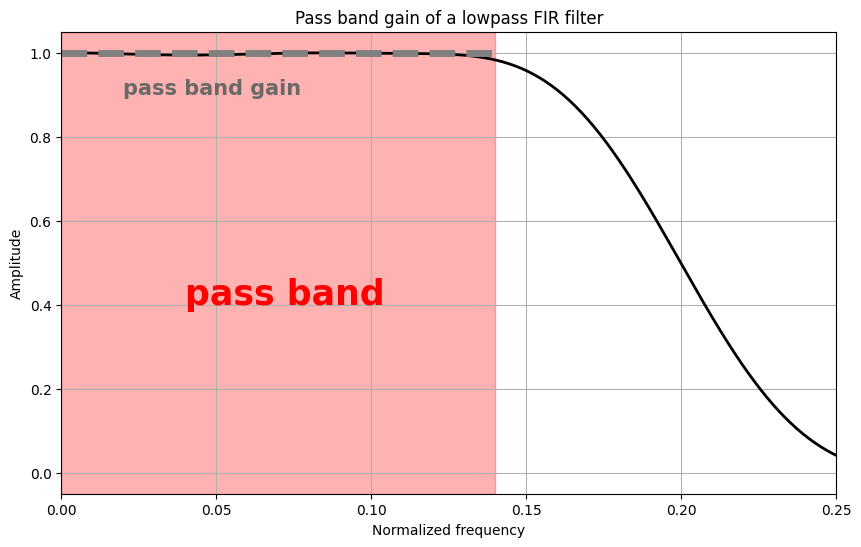

In [120]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, 0.5, len(H)), H,color='black',lw=2)
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude')
plt.title('Pass band gain of a lowpass FIR filter')
plt.xlim(0,0.25)
plt.grid()
plt.annotate('pass band',(0.04,0.4),size=25,color='red',weight='bold')
plt.annotate('pass band gain',(0.02,0.9),size=15,color='dimgrey',weight='bold')
plt.axvspan(0,.14,color='red',alpha=.3)
plt.hlines(y=1.00,xmin=0, xmax=0.14,color='grey',lw=5,linestyles='--')

Filter gain in the pass band should be close to one (unity). 

When we talk about gain in the stop band, we talk about the *negative* of gain. In logarithmic terms, for example, a stop band gain of -80 would mean that the filter attenuates at an amplitude of 80dB:

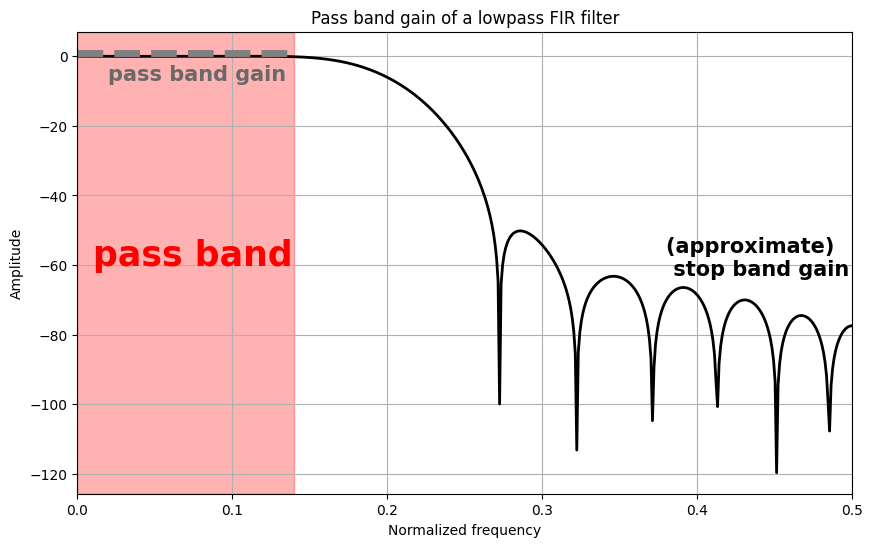

In [121]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, 0.5, len(H)), 20 * np.log10(H),color='black',lw=2)
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude')
plt.title('Pass band gain of a lowpass FIR filter')
plt.xlim(0,0.5)
plt.grid()
plt.annotate('pass band',(0.01,-60),size=25,color='red',weight='bold')
plt.annotate('pass band gain',(0.02,-7),size=15,color='dimgrey',weight='bold')
plt.annotate('(approximate) \n stop band gain',(0.38,-63),size=15,color='black',weight='bold')
plt.axvspan(0,.14,color='red',alpha=.3)
plt.hlines(y=1.00,xmin=0, xmax=0.14,color='grey',lw=5,linestyles='--')

The filter plotted above is an example of an *unnormalized* filter gain. But sometimes we want to normalize the filter gain if we, for example, wanted to approximate a certain amplitude level in the filter. We do this by dividing each filter coefficient by the sum of all coefficients. The sum of all coefficients is the same as the filter gain at 0Hz, i.e. the DC bias. Again, in the plot above the DC bias=1 (0dB on a logarithmic scale), so we don't need to divide by the sum of all coefficients. But we can still change the filter gain by scaling the coefficients as I do in the code below. You'll see that changing the filter's gain will never change the shape of the filter's frequency magnitude response:

Text(0.025, -4, 'pass band gain=unity (1) \n or 0 dB')

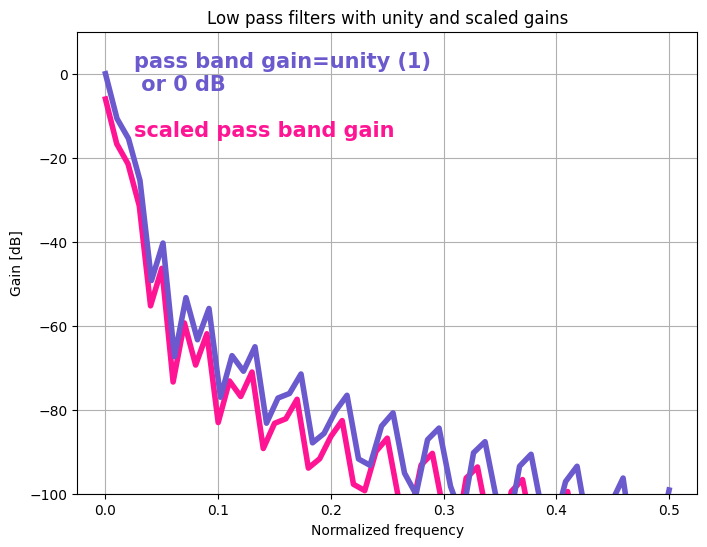

In [128]:
scalar = 2 # try plugging in different values here to view the effect on filter gain in the plot below

gain_h = []
for coef in h:
    norm_coef = coef/scalar
    gain_h.append(norm_coef)
 
# compute frequency magnitude responses from coefficients and keep first half
H = np.abs(fft(h))[0 : len(h)//2]
H_gain = np.abs(fft(gain_h))[0 : len(gain_h)// 2 + 1]

plt.figure(figsize=(8,6))
plt.plot(np.linspace(0, 0.5, len(H_gain)), 20 * np.log10(H_gain), color='deeppink',lw=4)
plt.plot(np.linspace(0, 0.5, len(H)), 20 * np.log10(H), color='slateblue',lw=4)
plt.xlabel('Normalized frequency')
plt.ylabel('Gain [dB]')
plt.title('Low pass filters with unity and scaled gains')
plt.ylim([-100, 10])
plt.grid()
plt.annotate('scaled pass band gain',(0.025,-15),size=15,color='deeppink',weight='bold')
plt.annotate('pass band gain=unity (1) \n or 0 dB',(0.025,-4),size=15,color='slateblue',weight='bold')

Of course changing the pass band gain in the plot above also changes the stop band gain.

## Interpreting signal processing language<a name="language"></a>

It's now time to put all of this new-found understanding of filter types, filter orders, and windowing functions to the test. Below I've quoted the methods from two different papers that employed a series of digital signal processing steps. These methods employ a lot of specialized language, so we'll take it step by step and will visualize the processing steps described as we go. 

The first signal processing method that we'll walk through describes the construction of a vocoder. A vocoder (so called because it encompases voice+encoder) has many different applications in speech and hearing sciences. One of the most common is to create acoustic simulations of what speech sounds like through a cochlear implant. Vocoder construction is actually covered in the next chapter of this tutorial series and a published paper (Cychosz et al., 2024, *Journal of the Acoustical Society of America*). 

"*For [normal hearing] listeners, speech and noise were processed by an acoustic simulation of a [cochlear implant]. Noise-band vocoder speech processing was implemented as follows. The input acoustic signal was bandpass filtered into several broad frequency bands (16, 8, or 4, depending on the test condition) using fourth-order Butterworth filters (-24 dB/octave)...The amplitude envelope was extracted from each band by half-wave rectification and low-pass filtering (fourth-order Butterworth) with a 160-Hz cutoff frequency. The extracted envelope from each band was used to modulate a wideband noise, which was then spectrally limited by a bandpass filter corresponding to the analysis band filter. Depending on the spectral smearing test condition, the slope of the carrier band filters was either -24 dB/octave (which matched the analysis band filter slope and simulated a [cochlear implant] with little channel interaction) or -6 dB/octave (which simulated a [cochlear implant] with significantly more channel interaction). The outputs from each band were summed..." (Fu & Nogaki, 2005: 21-22).* 

So the authors here have employed a series of filtering steps to simulate different degrees of interaction between electrodes on a cochlear implant array. That is...pretty cool. Let's walk through their description to make sense of each signal processing step. 

"*The input acoustic signal was bandpass filtered into several broad frequency bands...using fourth-order Butterworth filters (-24 db/octave)."*

Let's pull out the terms that we recognize and interpret what the authors did:

* bandpass filter: refers to the frequencies within the filter; the authors constructed a series of filters that attenuated frequencies below and above a certain range
* fourth order: refers to the steepness of the transition band; the authors determined that the transition band should be -24 dB/octave
* Butterworth filters: refers to the relationship between passband ripple and transition band; the authors chose Butterworth because it has a very flat frequency response in the passband

"*The amplitude envelope was extracted from each band by half-wave rectification and low-pass filtering (fourth-order Butterworth) with a 160-Hz cutoff frequency."*

Okay, this one is tricky. Let's start with what we remember from the amplitude modulation tutorial:

* half-wave rectification: this is a fancy way of saying take the absolute value of the amplitude in the time domain; the authors used this to derive the shape of the signal's amplitude over time  

Next the authors refer to a low-pass filter. But be careful here. Many users (myself included, originally) assume that low-pass filters only occur in the frequency domain where we attenuate frequencies above a certain amount. Instead, this low-pass filter is in the *time* domain and we are filtering out higher frequency modulations (above 160Hz) in the temporal envelope. 

* low-pass filtering (in the time domain): only sampling the amplitude <160Hz in the time domain

"*The extracted envelope from each band was used to modulate a wideband noise, which was then spectrally limited by a bandpass filter corresponding to the analysis band filter.*" 

We'll talk more about this processing step in the vocoder tutorial.

"*Depending on the spectral smearing test condition, the slope of the carrier band filters was either -24 dB/octave (which matched the analysis band filter slope and simulated a [cochlear implant] with little channel interaction) or -6 dB/octave (which simulated a [cochlear implant] with significantly more channel interaction)."*

* the "filters" described here are the digital filters that you've been learning to apply in this tutorial. The differences correspond to the steepness in the roll-off, which we explored above. 